# Demo - UCI Data - RBIG

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", True)

import chex
import numpy as np
from functools import partial

from rbig_jax.models import RBIG


KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

%matplotlib inline

sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)

%load_ext lab_black

%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Download Data

#### Create Directory

In [3]:
from pathlib import Path


# create target directory
target_dir = Path(root).joinpath("datasets/uci")

# create directory if it doesn't exist
try:
    Path(target_dir).mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"Folder '{target_dir}' Is Already There.")
else:
    print(f"Folder '{target_dir}' is created.")

Folder '/home/emmanuel/code/rbig_jax/datasets/uci' Is Already There.


#### Download from URL

In [4]:
import urllib.request

url = "https://zenodo.org/record/1161203/files/data.tar.gz"

ds_dir = str(Path(target_dir).joinpath(str(Path(url).name)))
urllib.request.urlretrieve(url, ds_dir)

('/home/emmanuel/code/rbig_jax/datasets/uci/data.tar.gz',
 <http.client.HTTPMessage at 0x7f4778b15400>)

#### Unzip File

In [5]:
import tarfile

ds_dir = str(Path(target_dir).joinpath(str(Path(url).name)))
tf = tarfile.open(ds_dir)
tf.extractall(target_dir)

## Gas

In [3]:
from rbig_jax.datasets.uci import GasDataModule

gas_datamodule = GasDataModule(standardize=True)

gas_datamodule.prepare_data()
gas_datamodule.setup()

In [4]:
data = gas_datamodule.ds_train[:100_000]
data_val = gas_datamodule.ds_val[:]
data_test = gas_datamodule.ds_test[:]

In [5]:
data.shape, data.min(), data.max()

((100000, 8), -5.169409054438384, 100.4517528934482)

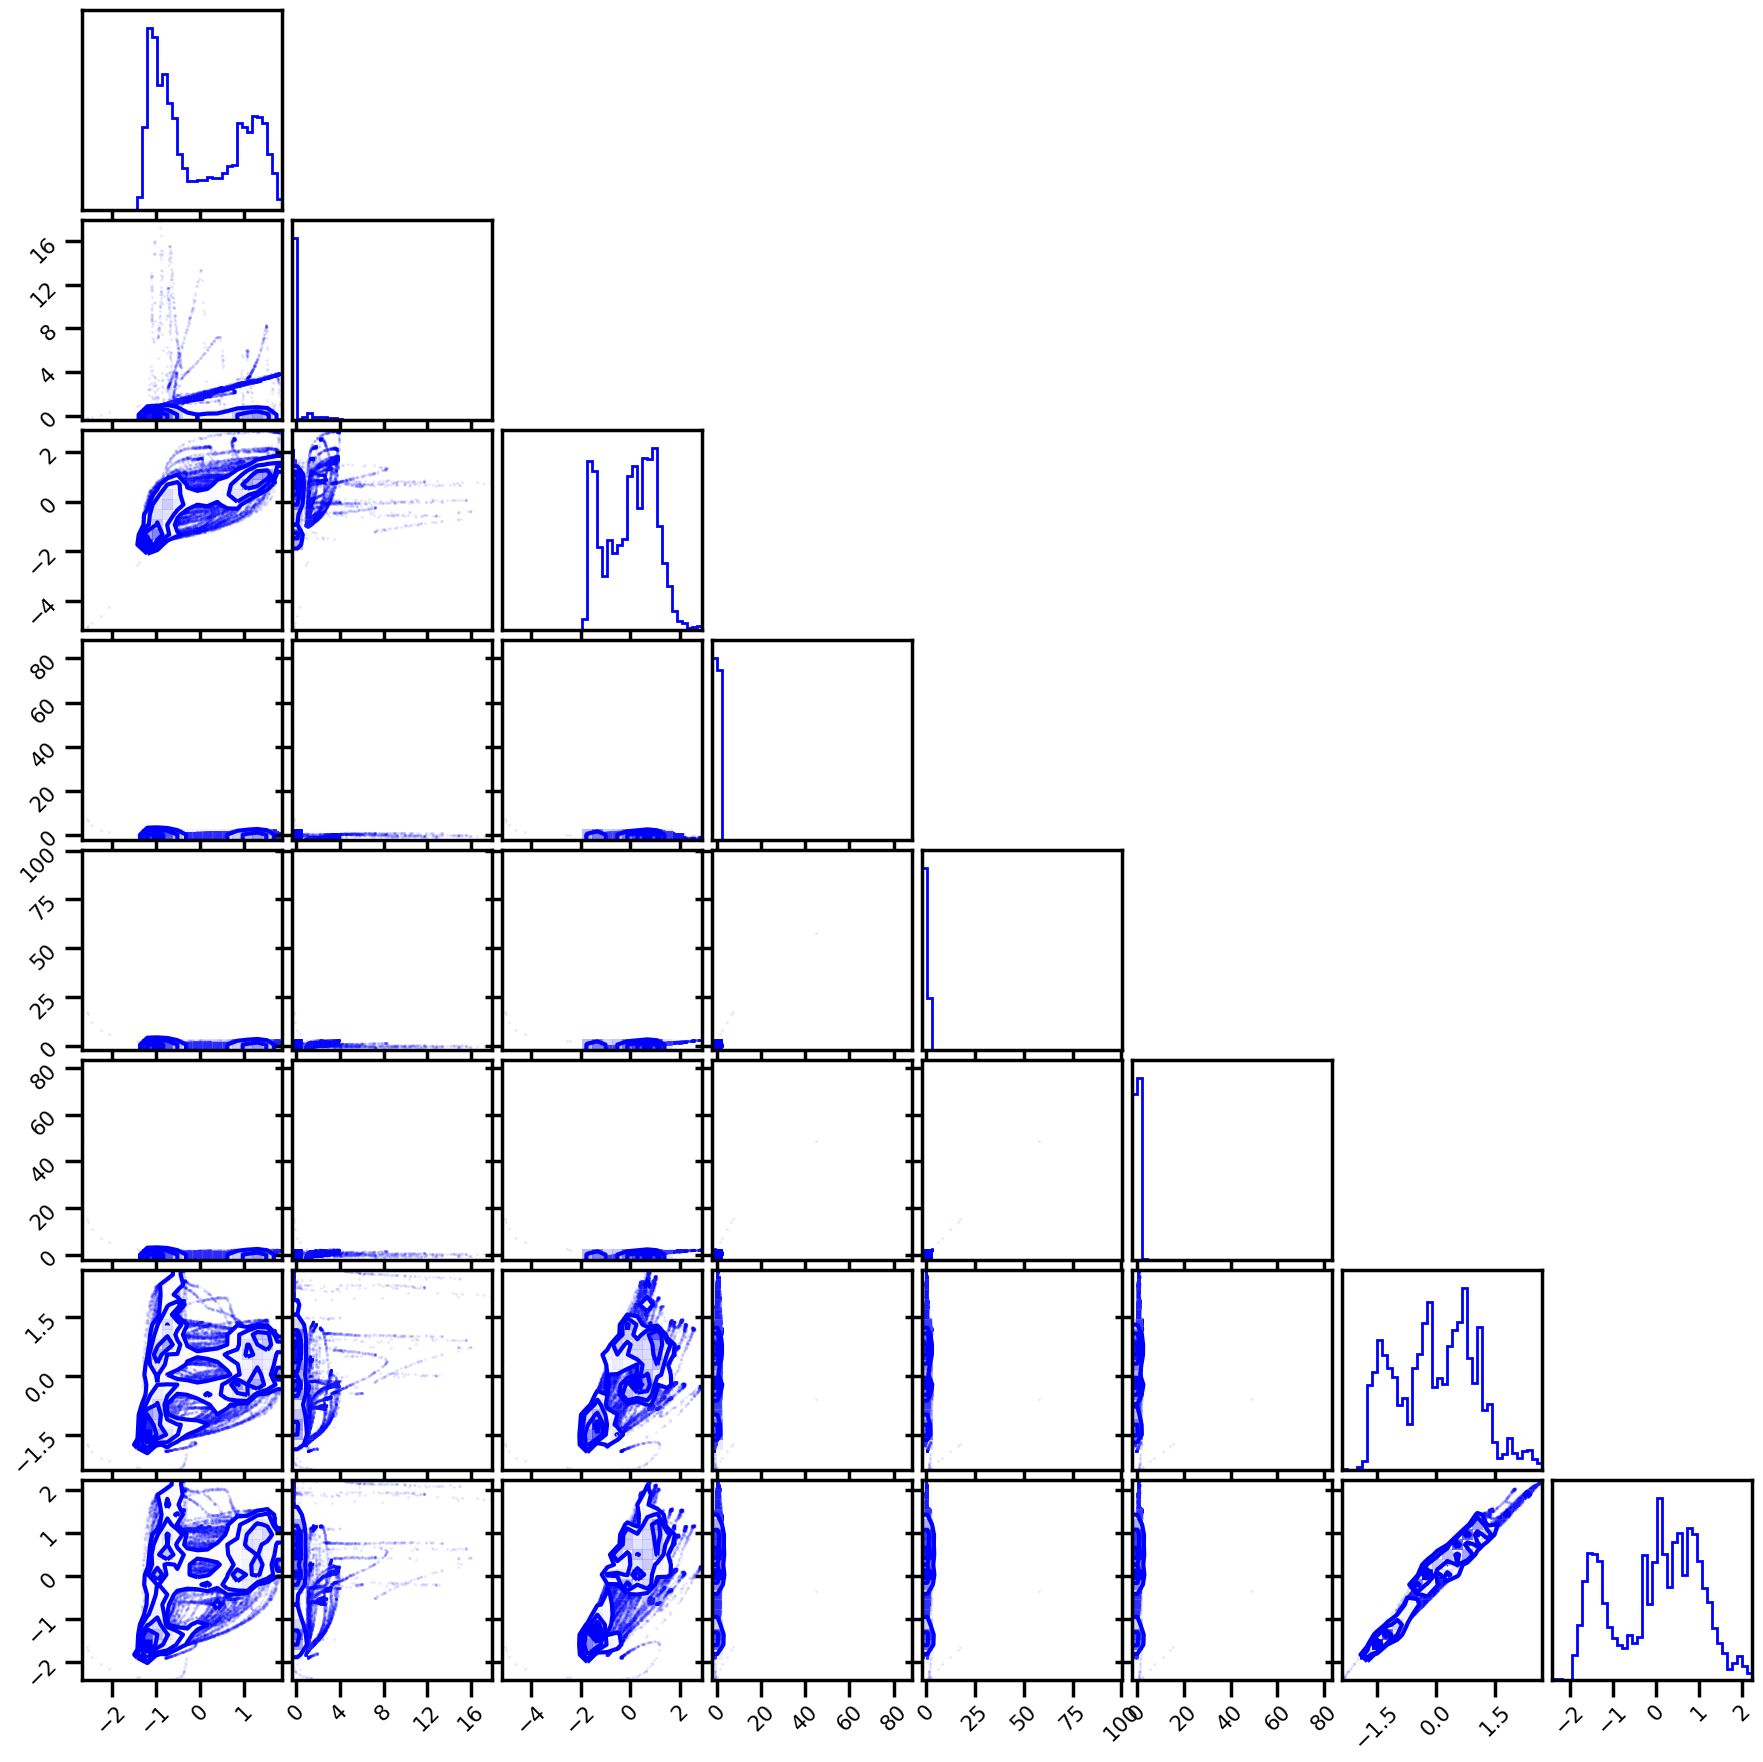

In [6]:
# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)
plt.show()

In [9]:
X = jnp.array(data, dtype=jnp.float32)

## Model

In [10]:
# a lot of parameters...
support_extension = 20
precision = 1_000
eps = 1e-5
method = "kde"
# Histogram specific params
nbins = None
alpha = 1e-5
# KDE specific params
bw = "scott"

# info reduction loss parameters
max_layers = 1_000
zero_tolerance = 60
p = 0.25
base = 2

# initialize the max layers parameters
verbose = True
n_layers_remove = 40
interval = 10

# everything (makes it fast...)
jitted = True

#### Training

In [ ]:
X_g, rbig_model = RBIG(
    X=X,
    support_extension=support_extension,
    method=method,
    precision=precision,
    alpha=alpha,
    nbins=nbins,
    bw=bw,
    eps=eps,
    max_layers=max_layers,
    zero_tolerance=zero_tolerance,
    p=p,
    base=base,
    verbose=verbose,
    n_layers_remove=n_layers_remove,
    interval=interval,
    jitted=jitted,
)

Layer 10 - Cum. Info Reduction: 15.056 - Elapsed Time: 133.9765 secs
Layer 20 - Cum. Info Reduction: 15.455 - Elapsed Time: 265.5648 secs
Layer 30 - Cum. Info Reduction: 15.584 - Elapsed Time: 397.0729 secs
Layer 40 - Cum. Info Reduction: 15.692 - Elapsed Time: 527.5105 secs
Layer 50 - Cum. Info Reduction: 15.747 - Elapsed Time: 658.0441 secs
Layer 60 - Cum. Info Reduction: 15.856 - Elapsed Time: 789.2297 secs
Layer 70 - Cum. Info Reduction: 15.898 - Elapsed Time: 920.0970 secs
Layer 80 - Cum. Info Reduction: 15.944 - Elapsed Time: 1051.4770 secs
Layer 90 - Cum. Info Reduction: 16.005 - Elapsed Time: 1182.5013 secs
Layer 100 - Cum. Info Reduction: 16.037 - Elapsed Time: 1313.7312 secs
Layer 110 - Cum. Info Reduction: 16.088 - Elapsed Time: 1444.6883 secs
Layer 120 - Cum. Info Reduction: 16.112 - Elapsed Time: 1575.4140 secs
Layer 130 - Cum. Info Reduction: 16.116 - Elapsed Time: 1707.2663 secs
Layer 140 - Cum. Info Reduction: 16.134 - Elapsed Time: 1839.0512 secs
Layer 150 - Cum. Info 

In [ ]:
# import joblib

In [ ]:

# # save the full model
# with open("rbig_model_test.pickle", "wb") as f:
#     pickle.dump(rbig_model, f)

### Gaussianized Data

#### Training Loop

In [ ]:
# plot data
fig = corner.corner(X_g, color="red", hist_bin_factor=2)
plt.show()

#### From Model

In [ ]:
%%time
X_g_ = rbig_model.forward(X)

# plot data
fig = corner.corner(X_g_, color="red", hist_bin_factor=2)
plt.show()

#### Information Reduction Evolution

In [ ]:
fig, ax = plt.subplots()
ax.plot(rbig_model.info_loss)
ax.set(xlabel="Iterations", ylabel="$\Delta$ Info. Reduction")
plt.show()

#### Negative Log-Likelihood

In [ ]:
nll = rbig_model.score(jnp.array(data_test, dtype=jnp.float32))
print(f"NLL Score: {nll:.4f}")

## Sampling

In [ ]:
%%time

# number of samples
n_samples = 100_000
seed = 42

X_samples = rbig_model.sample(seed=seed, n_samples=n_samples)

In [ ]:
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Saving and Loading

Often times it would be nice to save and load models. This is useful for checkpointing (during training) and also for convenience if you're doing research on google colab.

Fortunately, everything here are python objects, so we can easily save and load our models via `pickle`.

#### Saving

Do to the internals of python (and design choices within this library), one can only store `objects`. So that includes the `rbig_block`, the `bijectors` and also the `rbig_model`. This does not include the `rbig_block_init` for example because that isn't an object, it's a function with some local params.

In [ ]:
# import pickle

# # save the blocks
# with open("rbig_block.pickle", "wb") as f:
#     pickle.dump(rbig_block, f)

# save the bijectors
# with open("bijectors.pickle", "wb") as f:
#     pickle.dump(bijectors, f)

# # save the full model
# with open("rbig_model_test.pickle", "wb") as f:
#     pickle.dump(rbig_model, f)
import joblib

joblib.dump(rbig_model, "rbig_model_gas.pickle")

#### Loading

Loading is straight forward!

In [ ]:
# with open("rbig_model.pickle", "rb") as f:
#     rbig_model_loaded = pickle.load(f)

rbig_model_loaded = joblib.load("rbig_model_gas.pickle")

#### Simple Test

They won't be the **exact same** byte-for-byte encoding. But they should give the same results either way :).

In [ ]:
# nll for the old model
nll = rbig_model.score(X)

# nll for the loaded model
nll_loaded = rbig_model_loaded.score(X)

# check that they're the same
chex.assert_tree_all_close(nll, nll_loaded)
print(f"NLL (Original): {nll:.4f}")
print(f"NLL (Loaded): {nll_loaded:.4f}")